# Image Captioning with OFA 🖼️📄
*Unifying Architectures, Tasks, and Modalities Through a Simple Sequence-to-Sequence Learning Framework*. Currently on of the SOTA in Image Captioning on COCO benchmark.

Here, we perform image captioning with pretrained OFA on the test images. Check out their [github repo](https://github.com/OFA-Sys/OFA) so that you can explore further, possibly training too. The model is a generic multi modal framework, which means a lot of tasks can be accomplished by it. Hence we infer our captions with the help of a question prompt asking the model to describe the image.

In [1]:
# Using the pre compiled wheel since we don't have internet on submission
!pip install -q /kaggle/input/stable-diffusion-data/transformers-4.18.0.dev0-py3-none-any.whl

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)


In [2]:
import os
import sys
import glob
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from transformers import OFATokenizer, OFAModel
from transformers.models.ofa.generate import sequence_generator

In [3]:
CKPT_DIR = "/kaggle/input/stable-diffusion-data/OFA-large-caption/"
IMAGE_DIR = "/kaggle/input/stable-diffusion-image-to-prompts/images"

BATCH_SIZE = 24

# Loading the pretrained OFA model 

In [4]:
mean, std = [0.5, 0.5, 0.5], [0.5, 0.5, 0.5]
resolution = 480
patch_resize_transform = transforms.Compose([
        lambda image: image.convert("RGB"),
        transforms.Resize((resolution, resolution), interpolation=Image.BICUBIC),
        transforms.ToTensor(), 
        transforms.Normalize(mean=mean, std=std)
    ])

tokenizer = OFATokenizer.from_pretrained(CKPT_DIR)
model = OFAModel.from_pretrained(CKPT_DIR, use_cache=False).cuda()
txt = " what does the image describe?"
inputs = tokenizer([txt], return_tensors="pt").input_ids

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  """
/opt/conda/lib/python3.7/site-packages/torchvision/transforms/transforms.py:333: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "


/kaggle/input/stable-diffusion-data/OFA-large-caption/
<super: <class 'OFATokenizer'>, <OFATokenizer object>>


/opt/conda/lib/python3.7/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /usr/local/src/pytorch/aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


# Model EDA
Lets see how the model is performing on the sample images!

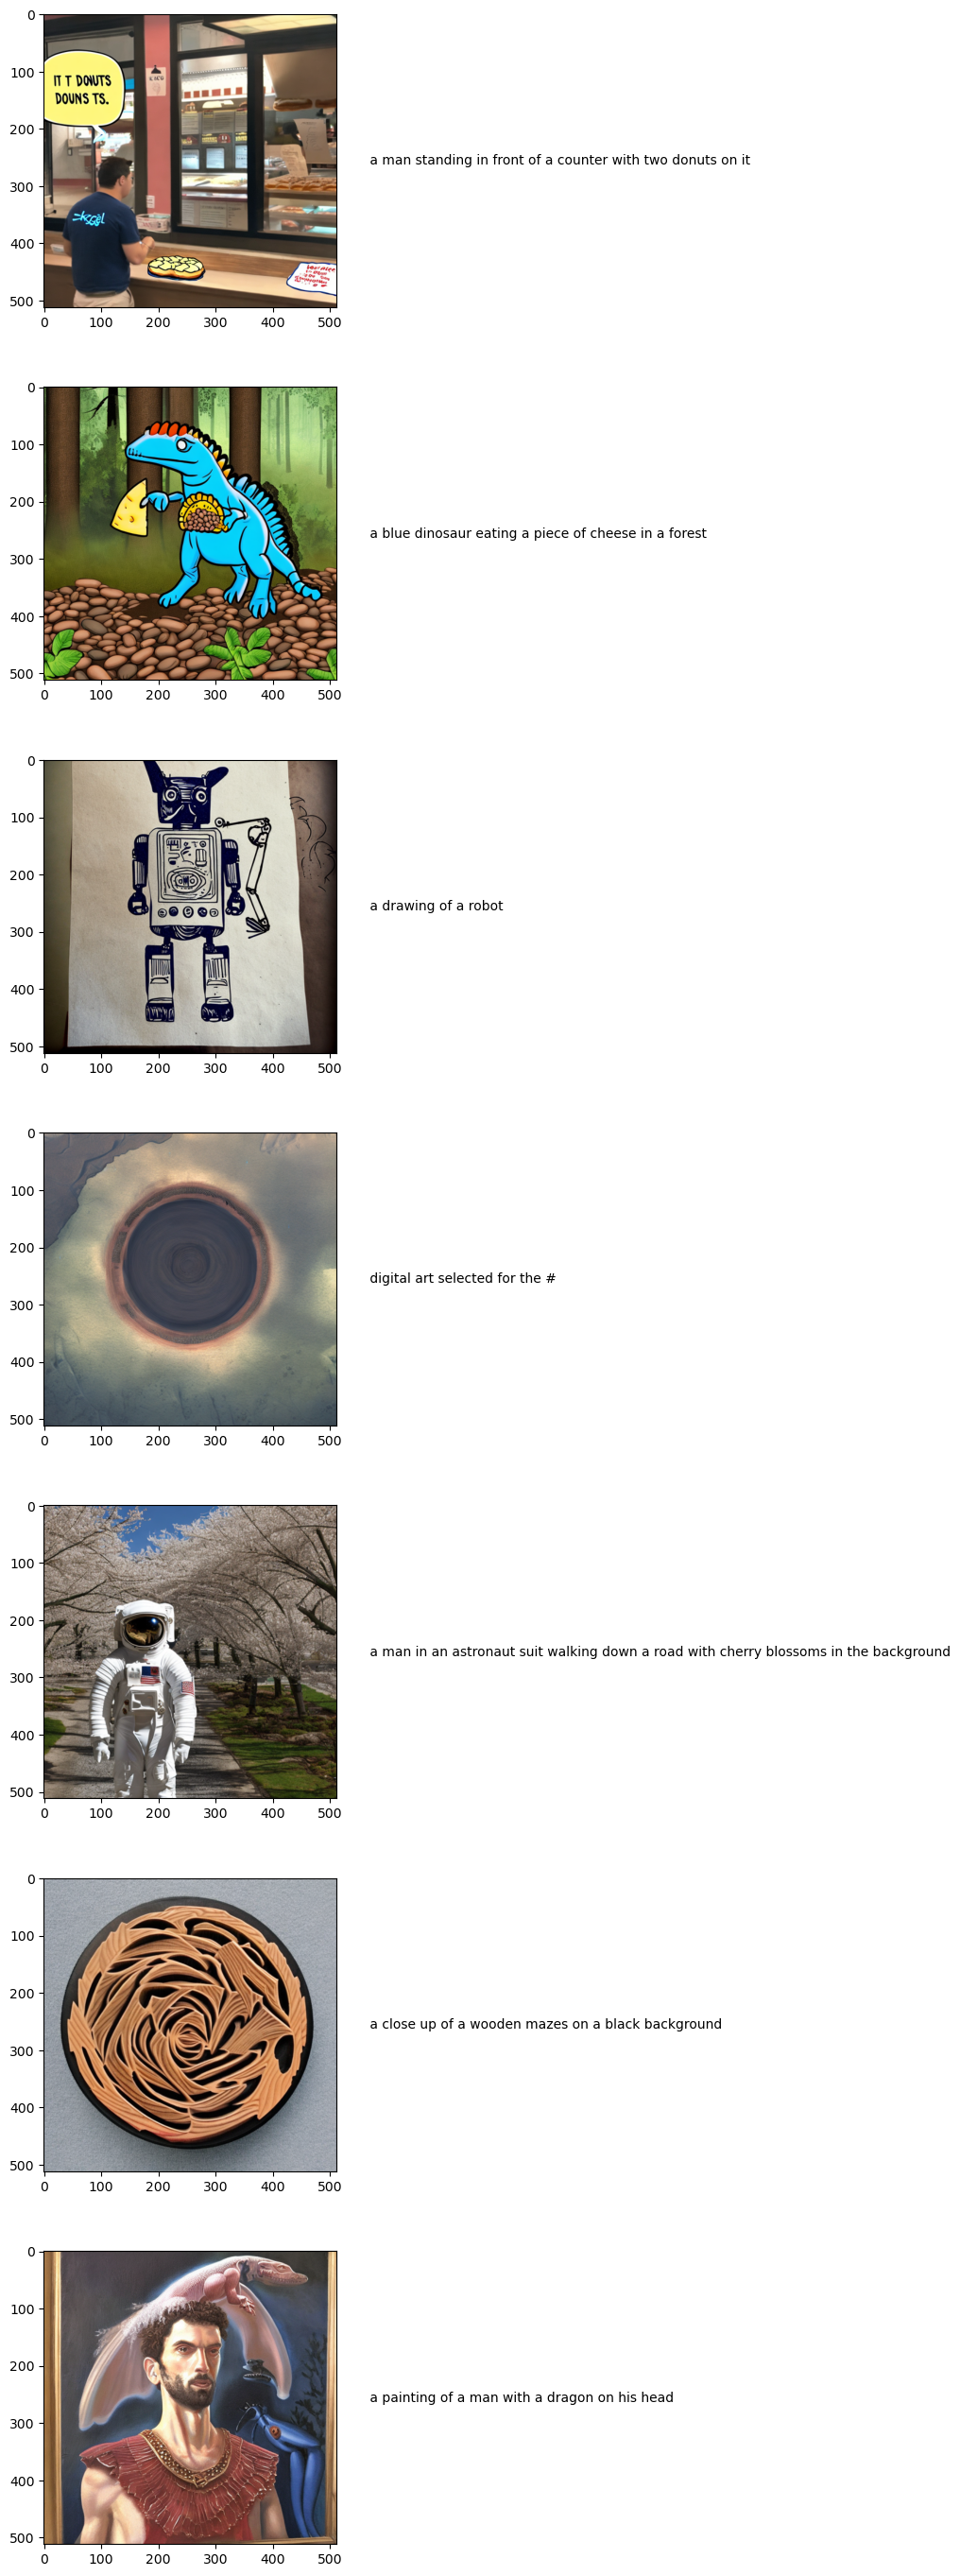

In [5]:
sample_images = glob.glob("/kaggle/input/stable-diffusion-image-to-prompts/images/*")[:7]
fig, ax = plt.subplots(7,1, figsize=(4,35))

for i,impath in enumerate(sample_images):
    image = Image.open(impath)
    image_t = patch_resize_transform(image).cuda().unsqueeze(0)
    out = model.generate(inputs.cuda(), patch_images=image_t.cuda(), num_beams=5, no_repeat_ngram_size=2)
    out_captions = tokenizer.batch_decode(out, skip_special_tokens=True)
    ax[i].imshow(image)
    ax[i].text(1.1, .5, out_captions[0], horizontalalignment='left', verticalalignment='center', transform=ax[i].transAxes)


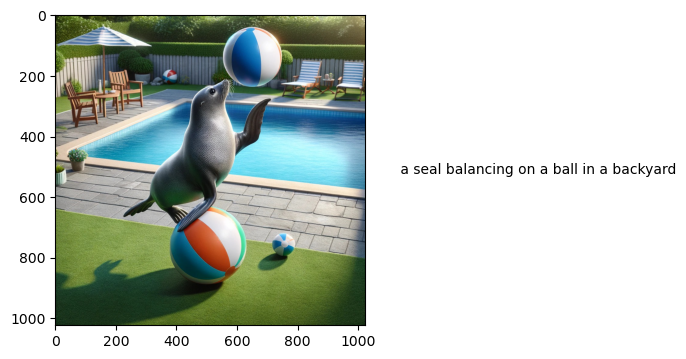

In [15]:
sample_images = glob.glob("/kaggle/input/seal-image/*")[:1]
fig, ax = plt.subplots(1,1, figsize=(4,35))
ax = [ax]
for i,impath in enumerate(sample_images):
    image = Image.open(impath)
    image_t = patch_resize_transform(image).cuda().unsqueeze(0)
    out = model.generate(inputs.cuda(), patch_images=image_t.cuda(), num_beams=5, no_repeat_ngram_size=2)
    out_captions = tokenizer.batch_decode(out, skip_special_tokens=True)
    ax[i].imshow(image)
    ax[i].text(1.1, .5, out_captions[0], horizontalalignment='left', verticalalignment='center', transform=ax[i].transAxes)

# Inference

Loading the embedding model required for submission, as provided by the organizers.

In [6]:
sys.path.append('../input/sentence-transformers-222/sentence-transformers')
from sentence_transformers import SentenceTransformer, models

comp_path = Path('../input/stable-diffusion-image-to-prompts/')
st_model = SentenceTransformer('/kaggle/input/sentence-transformers-222/all-MiniLM-L6-v2')

A simple Image Loader to make our life easier!

In [7]:
class ImageGen(Dataset):
    def __init__(self, root, batch_size=32):
        self.root = root
        self.im_paths = os.listdir(self.root)
        self.batch_size = batch_size
        self.sz = len(self.im_paths)
        self.genlen = self.sz//self.batch_size + int(self.sz%self.batch_size > 0)
        
    def __getitem__(self, index):
        if index >= self.genlen:
            raise IndexError("Out of bounds")
        
        l, r = index*self.batch_size, min(self.sz, (index+1)*self.batch_size)
        
        f_paths = [os.path.join(self.root, self.im_paths[i]) for i in range(l,r)]
        f_ids = [self.im_paths[i][:-4] for i in range(l,r)]
        
        ims = [Image.open(f_path) for f_path in f_paths]
        ims = [patch_resize_transform(im).cuda().unsqueeze(0) for im in ims]
        ims = torch.cat(ims)
        
        return ims, f_ids
    
    def __len__(self):
        return self.genlen
        

Inference loop! Here we also utilize the idea from https://www.kaggle.com/code/yawata/post-processing-adding-modifiers to add modifiers to the output caption.

In [8]:
sub_ids = []
sub_embeds = []

imgen = ImageGen(IMAGE_DIR, BATCH_SIZE)

for b in imgen:
    for j in range(len(b[1])):
        sub_ids.extend([f"{b[1][j]}_{i}" for i in range(384)])
    
    img_batch = b[0]
    out = model.generate(inputs.repeat(len(img_batch), 1).cuda(), patch_images=img_batch, num_beams=5, no_repeat_ngram_size=2)
    out_captions = tokenizer.batch_decode(out, skip_special_tokens=True)
    out_captions = [cap + ", fine details, masterpiece" for cap in out_captions]
    
    embeddings = st_model.encode(out_captions).flatten()
    sub_embeds.extend(embeddings)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

# Submission

In [9]:
sub = pd.DataFrame({"imgId_eId": sub_ids, "val": sub_embeds})
print(sub.shape)
sub.head()

(2688, 2)


,imgId_eId,val
0,f27825b2c_0,-0.053490
1,f27825b2c_1,0.086959
2,f27825b2c_2,-0.019802
3,f27825b2c_3,-0.007962
4,f27825b2c_4,-0.111328


In [10]:
sub.to_csv("submission.csv", index=False)